# Data Analytics on Stackoverflow Data

## Backend

### Install and import dependencies

In [20]:
!pip install requests-html requests pandas

In [21]:
!pip install seaborn

In [22]:
import requests
from requests_html import HTML
import numpy as np
import pandas as pd
import random
import os
import time
import warnings
from tqdm import tqdm_notebook
from collections import Counter
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

warnings.filterwarnings("ignore")

plt.rcParams['figure.figsize'] = (10.0, 10.0)

### Scraping multiple pages

#### Functions for data manupulation and cleaning

In [23]:
def clean_scraped_data(text, keyname=None):
  if keyname == 'user_name':
    return text.split("\n")[0]
  if keyname == 'votes':
      if text != '1\nvote':
        return text.replace('\nvotes', '')
      else:
        return text.replace('\nvote', '')
  if keyname == 'views':
      return text.replace(' views', '')
  if keyname == 'num_answers':
    if text != '1answer':
      return text.replace('answers', '')
    else:
      return text.replace('answer', '')
  return text

In [24]:
def evaluate(text, keyname=None):
  if keyname == 'votes' or keyname == 'views' or keyname == 'num_answers':
    if text[-1] == 'k':
      text = pd.eval(text.replace('k', ' * 10**3',1))
    elif text[-1] == 'm':
      text = pd.eval(text.replace('m', ' * 10**6',1))
  return text

#### Function for Parsing the web page

In [25]:
def parse_tagged_page(html):
  question_summaries = html.find(".question-summary")
  key_names = ['question', 'votes', 'views', 'num_answers', 'tags', 'user_name', 'date']
  classes_names = ['.question-hyperlink', '.vote', '.views', '.status', '.tags', '.user-details', '.relativetime']
  datas = []
  for el in question_summaries:
      question_data = {} 
      for i, _class in enumerate(classes_names):
          sub_el = el.find(_class, first=True)
          keyname = key_names[i]
          question_data[keyname] = clean_scraped_data(sub_el.text, keyname=keyname)
          question_data[keyname] = evaluate(question_data[keyname], keyname=keyname)

      datas.append(question_data)
  return datas

#### Function for Extracting the data from url

In [26]:
def extract_data_from_url(url):
  res = requests.get(url)
  if res.status_code not in range(200, 299):
      print("HTML response failure, retrying..")
      return []
  html_str = res.text
  html = HTML(html=html_str)
  datas = parse_tagged_page(html)
  return datas

#### Function that estimates the sort query filter

In [27]:
def filter_sort(filter = None):
  if filter == '1':
    return "Newest"
  elif filter == '2':
    return "RecentActivity"
  elif filter == '3':
    return "MostVotes"
  elif filter == '4':
    return "MostFrequent"
  elif filter == '5':
    return "BountyEndingSoon"
  else:
    return []

#### Main function for Scraping data 

In [28]:
def scrape_tag(tag = None, query_filter = None, max_pages=20):
  base_url = 'https://stackoverflow.com/questions/tagged/'
  datas = []
  for p in range(max_pages):
      page_num = p + 1
      url = f"{base_url}{tag}?sort={query_filter}&page={page_num}"
      print(url)
      datas += extract_data_from_url(url)
      time.sleep(1.2)
  df = pd.DataFrame(datas)
  df['votes'] = df['votes'].astype(int)
  df['num_answers'] = df['num_answers'].astype(int)
  df['views'] = df['views'].astype(int)
  df.to_csv(tag+"_scraped.csv", index=False)
  return df

### Data Analysis functions

#### Analyse Votes



In [29]:
def ip_1(df=None):
  print("\nAnalyse Votes")
  sns.boxplot(df['votes'])
  plt.show()
  df['votes'].value_counts()/len(df)*100
  sns.countplot(df['votes'])
  plt.show()

#### Analyse Number of Answers


In [30]:
def ip_2(df=None):
  print("\nAnalyse Number of Answers")
  sns.boxplot(df['num_answers'])
  plt.show()
  df['num_answers'].value_counts()/len(df)*100
  sns.countplot(df['num_answers'])
  plt.show()

#### Analyse Views


In [31]:
def ip_3(df=None):
  print("\nAnalyse Views")
  sns.boxplot(df['views'])
  plt.show()
  df['views'].value_counts()/len(df)*100
  sns.countplot(df['views'])
  plt.show()

#### Are the tags mentioned in questions similar to each other?


In [32]:
def ip_4(df=None):
  print("\nAre the tags mentioned in questions similar to each other?")
  tags = []
  for tag in list(df['tags']):
    tags.append(tag.split(' '))

  embedding = Word2Vec(tags, sg=1, size=256, min_count=1)
  X = embedding[embedding.wv.vocab]
  pca = PCA(n_components=2)
  result = pca.fit_transform(X)

  fig, ax = plt.subplots()
  ax.plot(result[:, 0], result[:, 1], 'o')
  ax.set_title('Embeddings - Spread')

  fig, ax = plt.subplots()
  ax.set_title('Embeddings - Annotated')
  ax.scatter(result[:25, 0], result[:25, 1])
  for j, txt in enumerate(list(embedding.wv.vocab)[:25]):
    ax.annotate(txt, result[j])
    
  plt.show()


#### Which tags are popularly used by Stackoverflow community in this domain?

In [33]:
def ip_5(df=None):
  print("\nWhich tags are popularly used by Stackoverflow community in this domain?")
  tags_list = list(df['tags'].unique())
  all_tags = []
  for tag in tqdm_notebook(tags_list):
      all_tags += tag.split(' ')

  count_tags = Counter(all_tags)
  tags_list = pd.DataFrame([list(count_tags.keys()), list(count_tags.values())])
  tags_list = tags_list.transpose()
  tags_list.columns = ['tags', 'counts']
  tags_list = tags_list.sort_values(by='counts', ascending=False)

  plt.barh(list(tags_list['tags'])[:25], list(tags_list['counts'])[:25])
  plt.ylabel('Tags -->')
  plt.xlabel('Count -->')
  plt.title('25 Most Popular Tags')
  plt.show()

#### How many tags are present per question?


In [34]:
def ip_6(df=None):
    print("\nHow many tags are present per question?")
    tags = list(df['tags'].unique())
    num_tags = []

    for tag_ in tqdm_notebook(tags):
        num_tags.append(len(tag_.split(' ')))

    num_tags = Counter(num_tags)

    plt.bar(list(num_tags.keys()), list(num_tags.values()))
    plt.xlabel('Number of tags -->')
    plt.ylabel('Number of questions -->')
    plt.title('Number of Tags per question')
    plt.show()

#### Are the number of views of question statistically related to number of answers?


In [35]:
def ip_7(df=None):
  print("\nAre the number of views of question statistically related to number of answers?")
  view_q = df[['views', 'num_answers']].drop_duplicates().reset_index(drop=True)
  display(view_q.astype(int).describe())

#### Are the tags related to Views?


In [36]:
def ip_8(df=None):
  print("\nAre the tags related to Views?")
  tag_views = df[['tags', 'views']].drop_duplicates().reset_index(drop=True)
  tagView = {}
  for i in tqdm_notebook(range(len(tag_views['tags']))):
      for tag in tag_views['tags'][i].split(' '):
          try:
              tagView[tag].append(tag_views['views'][i])
          except Exception:
              tagView[tag] = [tag_views['views'][i]]
  tagViewAvg = {}
  for key in list(tagView.keys()):
      tagViewAvg[key] = np.average(tagView[key])

  tagViewAvg = pd.DataFrame([list(tagViewAvg.keys()), list(tagViewAvg.values())])
  tagViewAvg = tagViewAvg.transpose()
  tagViewAvg.columns = ['tags', 'views']
  tagViewAvg = tagViewAvg.sort_values('views')

  plt.barh(list(tagViewAvg['tags'])[-25:], list(tagViewAvg['views'])[-25:])
  plt.xlabel('Average number of Views -->')
  plt.ylabel('Tags -->')
  plt.title('25 - Most Popular Tags')
  plt.show()

  fig, ax = plt.subplots(2, 2)

  ax[0][0].plot([0] + tagView['python'])
  ax[0][0].set_title('python')

  ax[0][1].plot([0] + tagView['c'])
  ax[0][1].set_title('c')

  ax[1][0].plot([0] + tagView['java'])
  ax[1][0].set_title('java')

  ax[1][1].plot([0] + tagView['c#'])
  ax[1][1].set_title('c#')
  plt.show()

#### Analyse Votes, Number of Answers, Views

In [37]:
def ip_9(df=None):
  print("\nAnalyse Votes, Number of Answers, Views")
  print("\nPair plot: ")
  sns.pairplot(df)
  plt.show()
  print("\nCorrelation plot: ")
  sns.heatmap(df.corr())
  plt.show()

## Front end

*********************************************************************** StackOverflow Data Analysis *************************************************************************************************
Hello!
On which domain would you like to perform the analysis?
Note: Enter domain names without blank space between them.
For example: Enter machine learning as machine-learning
machine-learning

Which filter would you like to apply?
1.Newest
2.Recent activity
3.Most votes
4.Most frequent
5.Bounty ending soon
4

https://stackoverflow.com/questions/tagged/machine-learning?sort=MostFrequent&page=1
https://stackoverflow.com/questions/tagged/machine-learning?sort=MostFrequent&page=2
https://stackoverflow.com/questions/tagged/machine-learning?sort=MostFrequent&page=3
https://stackoverflow.com/questions/tagged/machine-learning?sort=MostFrequent&page=4
https://stackoverflow.com/questions/tagged/machine-learning?sort=MostFrequent&page=5
https://stackoverflow.com/questions/tagged/machine-learning?sor

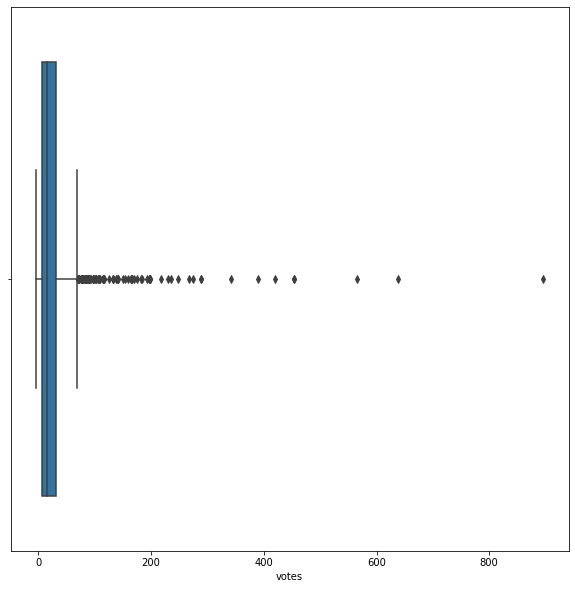

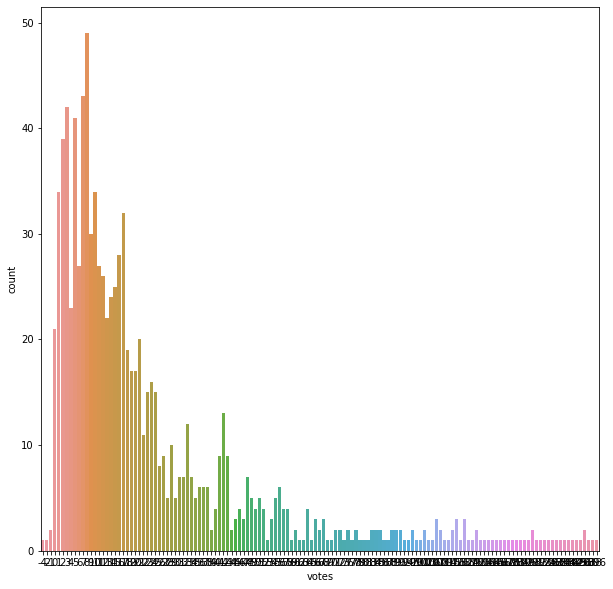




Which analysis would you like to perform?
1.Analyse Votes
2.Analyse Number of Answers
3.Analyse Views
4.Are the tags mentioned in questions similar to each other?
5.Which tags are popularly used by Stackoverflow community in this domain?
6.How many tags are present per question?
7.Are the number of views of question statistically related to number of answers?
8.Are the tags related to Views?
9.Analyse Votes, Number of Answers, Views
10.Exit
2

Analyse Number of Answers


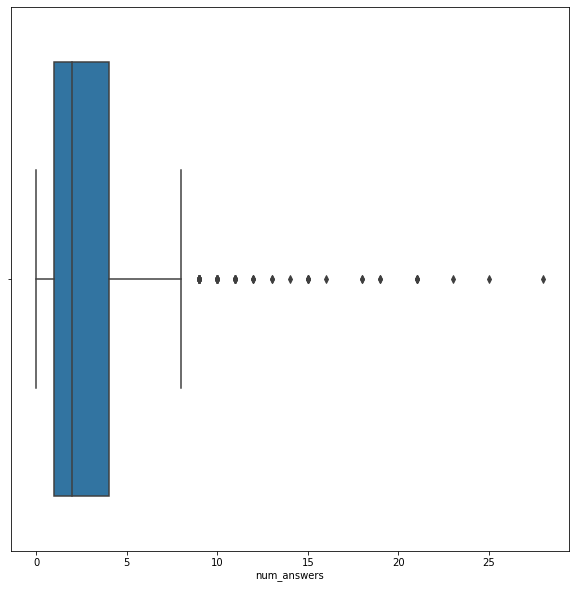

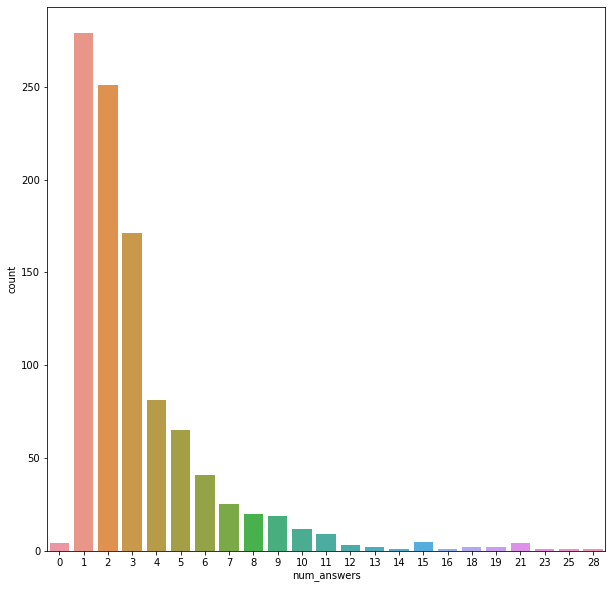




Which analysis would you like to perform?
1.Analyse Votes
2.Analyse Number of Answers
3.Analyse Views
4.Are the tags mentioned in questions similar to each other?
5.Which tags are popularly used by Stackoverflow community in this domain?
6.How many tags are present per question?
7.Are the number of views of question statistically related to number of answers?
8.Are the tags related to Views?
9.Analyse Votes, Number of Answers, Views
10.Exit
3

Analyse Views


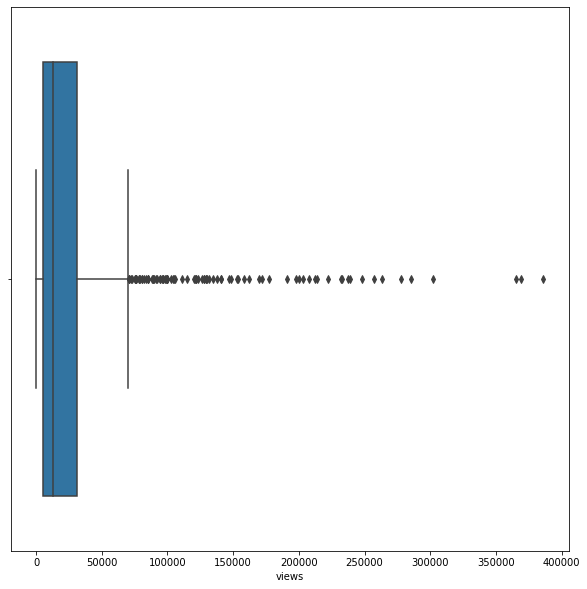

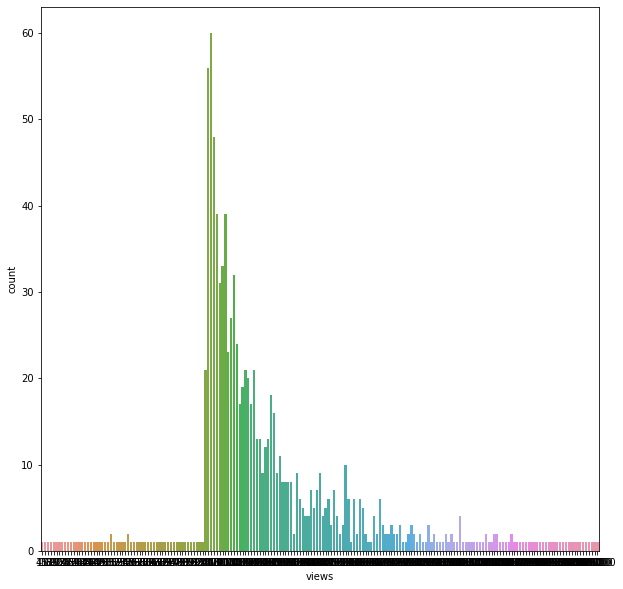




Which analysis would you like to perform?
1.Analyse Votes
2.Analyse Number of Answers
3.Analyse Views
4.Are the tags mentioned in questions similar to each other?
5.Which tags are popularly used by Stackoverflow community in this domain?
6.How many tags are present per question?
7.Are the number of views of question statistically related to number of answers?
8.Are the tags related to Views?
9.Analyse Votes, Number of Answers, Views
10.Exit
4

Are the tags mentioned in questions similar to each other?


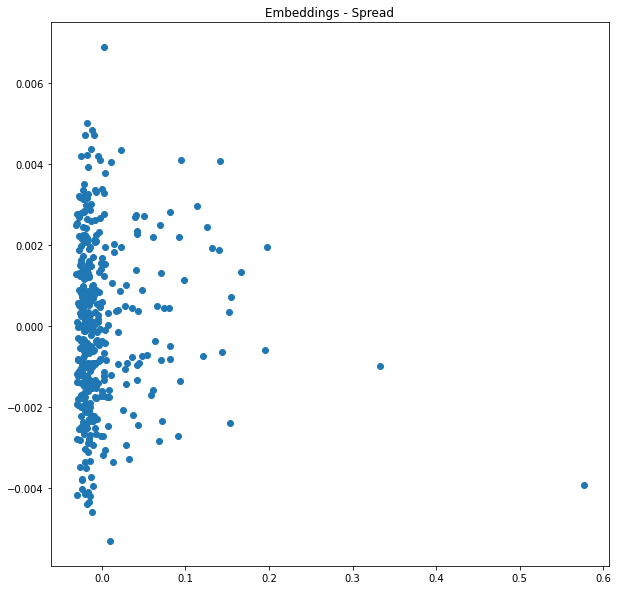

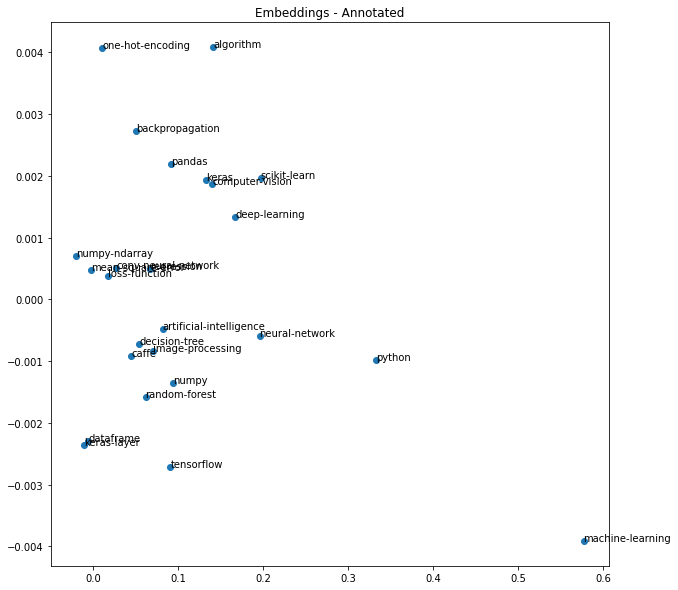




Which analysis would you like to perform?
1.Analyse Votes
2.Analyse Number of Answers
3.Analyse Views
4.Are the tags mentioned in questions similar to each other?
5.Which tags are popularly used by Stackoverflow community in this domain?
6.How many tags are present per question?
7.Are the number of views of question statistically related to number of answers?
8.Are the tags related to Views?
9.Analyse Votes, Number of Answers, Views
10.Exit
5

Which tags are popularly used by Stackoverflow community in this domain?


  0%|          | 0/821 [00:00<?, ?it/s]

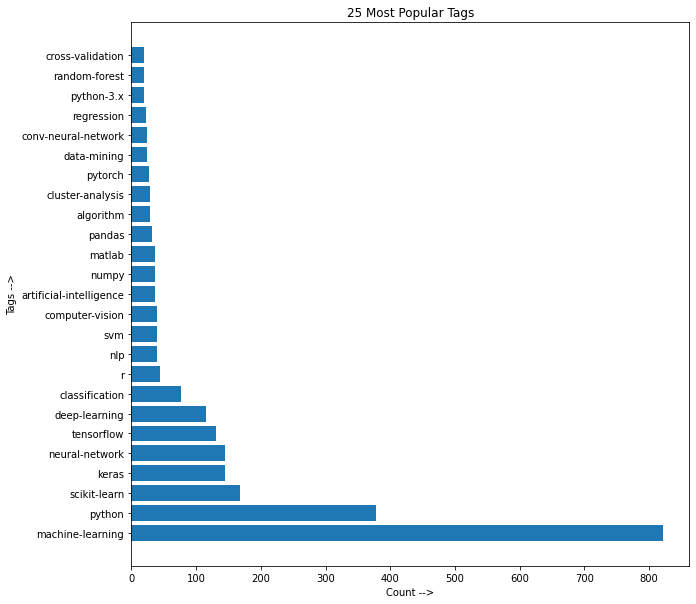




Which analysis would you like to perform?
1.Analyse Votes
2.Analyse Number of Answers
3.Analyse Views
4.Are the tags mentioned in questions similar to each other?
5.Which tags are popularly used by Stackoverflow community in this domain?
6.How many tags are present per question?
7.Are the number of views of question statistically related to number of answers?
8.Are the tags related to Views?
9.Analyse Votes, Number of Answers, Views
10.Exit
6

How many tags are present per question?


  0%|          | 0/821 [00:00<?, ?it/s]

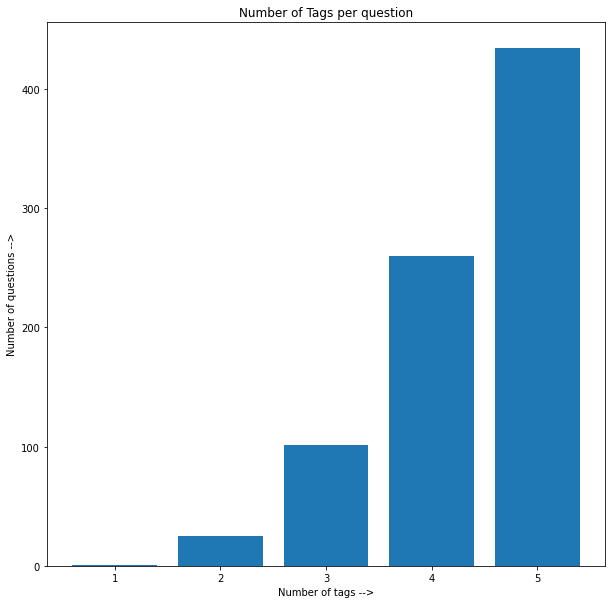




Which analysis would you like to perform?
1.Analyse Votes
2.Analyse Number of Answers
3.Analyse Views
4.Are the tags mentioned in questions similar to each other?
5.Which tags are popularly used by Stackoverflow community in this domain?
6.How many tags are present per question?
7.Are the number of views of question statistically related to number of answers?
8.Are the tags related to Views?
9.Analyse Votes, Number of Answers, Views
10.Exit
7

Are the number of views of question statistically related to number of answers?


,views,num_answers
count,439.000000,439.000000
mean,48743.164009,4.781321
std,60072.147189,4.115625
min,45.000000,0.000000
25%,11000.000000,2.000000
50%,31000.000000,4.000000
75%,60500.000000,6.000000
max,386000.000000,28.000000





Which analysis would you like to perform?
1.Analyse Votes
2.Analyse Number of Answers
3.Analyse Views
4.Are the tags mentioned in questions similar to each other?
5.Which tags are popularly used by Stackoverflow community in this domain?
6.How many tags are present per question?
7.Are the number of views of question statistically related to number of answers?
8.Are the tags related to Views?
9.Analyse Votes, Number of Answers, Views
10.Exit
8

Are the tags related to Views?


  0%|          | 0/982 [00:00<?, ?it/s]

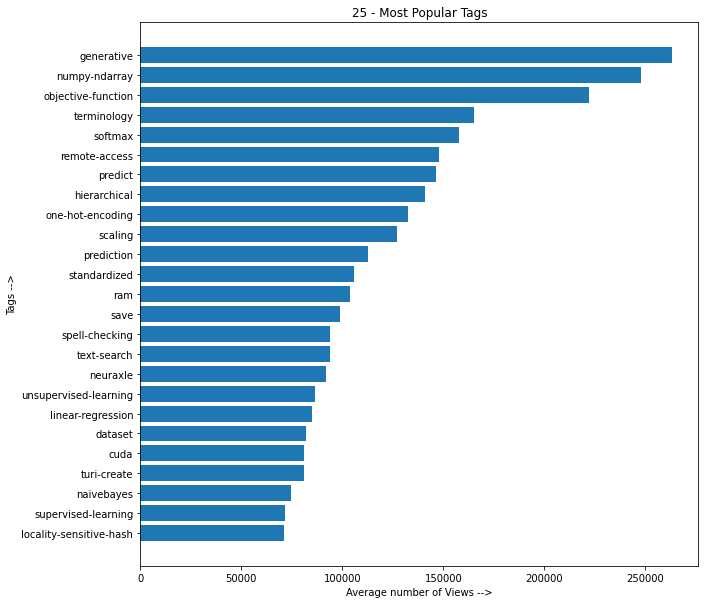

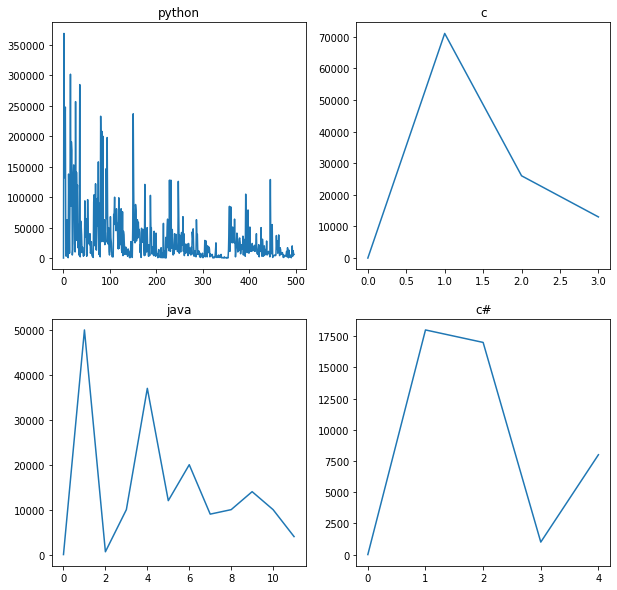




Which analysis would you like to perform?
1.Analyse Votes
2.Analyse Number of Answers
3.Analyse Views
4.Are the tags mentioned in questions similar to each other?
5.Which tags are popularly used by Stackoverflow community in this domain?
6.How many tags are present per question?
7.Are the number of views of question statistically related to number of answers?
8.Are the tags related to Views?
9.Analyse Votes, Number of Answers, Views
10.Exit
9

Analyse Votes, Number of Answers, Views

Pair plot: 


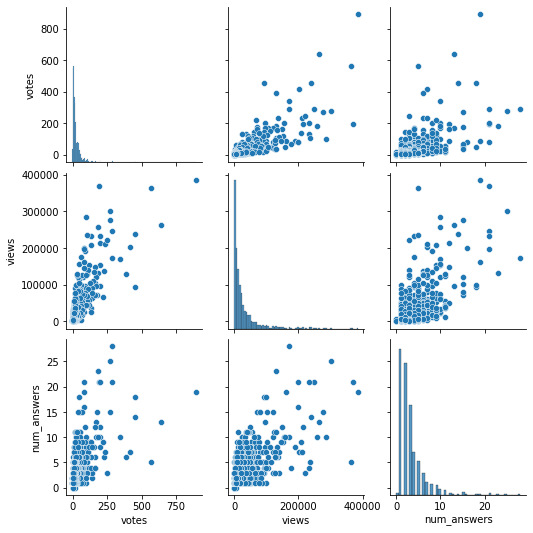


Correlation plot: 


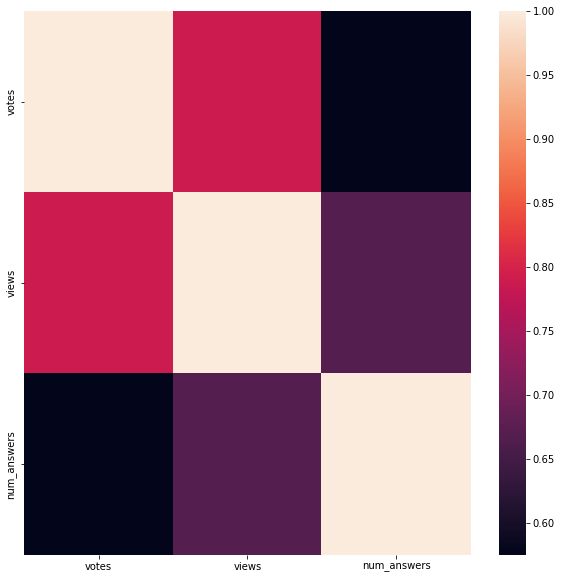




Which analysis would you like to perform?
1.Analyse Votes
2.Analyse Number of Answers
3.Analyse Views
4.Are the tags mentioned in questions similar to each other?
5.Which tags are popularly used by Stackoverflow community in this domain?
6.How many tags are present per question?
7.Are the number of views of question statistically related to number of answers?
8.Are the tags related to Views?
9.Analyse Votes, Number of Answers, Views
10.Exit
10


In [38]:
print("*********************************************************************** StackOverflow Data Analysis *************************************************************************************************")

TAG = input("Hello!\nOn which domain would you like to perform the analysis?\nNote: Enter domain names without blank space between them.\nFor example: Enter machine learning as machine-learning\n")
filter = input("\nWhich filter would you like to apply?\n1.Newest\n2.Recent activity\n3.Most votes\n4.Most frequent\n5.Bounty ending soon\n")
FILTER = filter_sort(filter)
print("\nCollecting data..")
df = scrape_tag(TAG,FILTER)
print("Data collection successful.")

ip = 0
while ip != '10':

  ip = input("\n\n\nWhich analysis would you like to perform?"
            "\n1.Analyse Votes"
            "\n2.Analyse Number of Answers"
            "\n3.Analyse Views"
            "\n4.Are the tags mentioned in questions similar to each other?"
            "\n5.Which tags are popularly used by Stackoverflow community in this domain?"
            "\n6.How many tags are present per question?"
            "\n7.Are the number of views of question statistically related to number of answers?"
            "\n8.Are the tags related to Views?"
            "\n9.Analyse Votes, Number of Answers, Views"
            "\n10.Exit\n")
  
  if ip == '1':
    ip_1(df)

  elif ip == '2':
    ip_2(df)

  elif ip == '3':
    ip_3(df)
  
  elif ip == '4':
    ip_4(df)

  elif ip == '5':
    ip_5(df)
  
  elif ip == '6':
    ip_6(df)

  elif ip == '7':
    ip_7(df)

    2
  elif ip == '8':
    ip_8(df)

  elif ip == '9':
    ip_9(df)
